# Normalizing Flows for Counterfactual Inference

Authors: Lily Bessette, Vincent Kennedy, Sam Stites

In this tutorial, we will replicate the work of the [Pyro Normalizing Flows Examples](https://pyro.ai/examples/normalizing_flows_i.html) within a PyroModule Framework. The PyroModule Framework will allow us to build a Structural Causal Model that we can perform the typical conditioning and do-calculus operations of on. We will demonstrate how to perform counterfactual inference on this concentric circle toy dataset (defined in donuts.py file). The PyroModule framework demonstrated here will be necessary for the steps of Twin-World Counterfactual Inference Algorithm.

## Table of Contents:
* **Background**
    * Introduction to Normalizing Flows 
    * Twin-World Counterfactual Inference Algorithm
* **Set Up PyroModule Framework**
    * Package Imports
    * Create Dataset 
    * Training Module
    * Flow-Based PyroModule Framework
* **Mirroring Normalizing Flows Pyro Tutorial in PyroModule Framework**
    * Flow-Based Univariate Model
    * Flow-Based Multivariate Model
    * Basic Flow-Based Conditional Model
* **Adding More Complexity to Conditional Models**
    * Basic Conditional Model with One Additional Noise Variable
    * Flow-Based Conditional Model with Continuous Context Variables
* **Implementation of Structural Causal Model with Normalizing Flows and Counterfactual Inference**
    * Conditional Affine Transform 
    * Structural Causal Model for Conditional Distributions
    * Infer Exogenous Variables and Perform Counterfactual Query
    * Plot the Twin World Counterfactual Result

# Background

## Normalizing Flows Basics

A normalizing flow is a kind of neural architecture and it describes a sequence of invertible mappings, which can be repeatedly applied to some initial density and by doing so transformed into a latent distribution. Thus, for a sequence of transformations, a valid probability distribution is obtained, and in general, this latent space is defined by Gaussians - hence it is a "normalizing flow" of the density into the Gaussian latent space. To recap, take each pixel in a data distribution and move each pixel by XYZ steps. At each step all of the pixels move in a direction of according to the neural network and then the neural network tries to direct the flow of pixels into some Gaussian form without conflicting with the initial data distribution. Normalizing flows allow for calculation of an exact likelihood and are flexible, invertible, and scalable. Additionally, in context to SCMs, normalizing flows do not increase the gradient space and does not break/add unnecessary complexity to the traditional gradient descent methods 

## Twin-World Counterfactual Inference Algorithm

1. **Abduction** - Predict the ‘state of the world’ (the exogenous noise, $\epsilon$) that is compatible with the observations, X, i.e. infer $P_{G}(\epsilon|x_1,x_2)$.
2. **Action** - Perform an intervention (e.g. $do(factor := \hat{0.1})$) corresponding to the desired manipulation, resulting in a modified SCM: 
$$SCM, \hat{G} = G{(x_1,x_2),do(factor := 0.1)} = (\hat{SCM}, P_{G}(\epsilon$|x_1,x_2)$$
3. **Prediction** - Compute the quantity of interest based on the distribution entailed by the counterfactual SCM, $P_{\hat{G}}(x_1,x_2)$.

# Set Up PyroModule Framework 

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import donuts
from donuts import compare, DonutsDataset, plot, smoke_test, sumall, get_logprobs, ConditionalAffineTransform

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
from time import sleep
from tqdm import tqdm, trange
from functools import reduce, partial
import inspect
from operator import itemgetter
from typing import *

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample, pyro_method
from pyro import poutine
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.distributions import constraints
from pyro.distributions import Normal, Bernoulli, TransformedDistribution
from pyro.distributions.torch_transform import ComposeTransformModule
from pyro.distributions.conditional import ConditionalTransformModule, ConditionalTransformedDistribution
from pyro.infer.reparam.transform import TransformReparam
import pyro.distributions.transforms as T
from pyro.distributions.transforms import ComposeTransform, SigmoidTransform, AffineTransform
from pyro.distributions import constraints
from pyro.nn import DenseNN
from pyro.distributions.torch_transform import ComposeTransformModule
from pyro.nn import DenseNN

import torch
from torch.distributions import Independent
from torch.optim import Adam
from torch import tensor, sigmoid
from torch.distributions.transforms import AffineTransform
import torch.distributions.transforms as TT
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Create Dataset

Set the seed, smoke_test on/off, number of samples for the data, and set up the visualize function from donuts.py.

In [4]:
pyro.set_rng_seed(1)
is_smoke_test = False
n_samples = 1000
dataset =  DonutsDataset(n_samples=n_samples, hole=None, noise=0.01, factor=0.3)
visualize=partial(donuts.visualize, dataset)

## Training Module

##### Standard Training Loop

Using our generative model, we use our observed data to condition the model on the data and extract a trace from the conditioned model. The built in functionality of a PyroModule is used to compute the log probabilities over the trace output. Then, the log probabilities are extracted over the specified observed values (i.e. over_vars). The element-wise sum is taken and then the mean is calculated. The loss is stored as the negative of this value and is minimized for optimization. 

The main nuance from a standard training loop in an normalizing flows setting is the clearing of the cache of the model's stateful flow variables at each optimization step.

Documentation:  [Adam Optimizer](http://docs.pyro.ai/en/0.3.0-release/optimization.html#pyro.optim.pytorch_optimizers.Adam) ,  [Optimizer](https://pytorch.org/docs/stable/optim.html)

In [5]:
def train(model, over_vars, dataset=dataset, n_epochs=500, lr=3e-3, n_samples=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    x1, x2 = [dataset.data[x] for x in ['x1', 'x2']]
    dataset.data['x1_x2'] = torch.cat([x1, x2], dim=-1)  # for univariates
    losses = []
    with trange(n_epochs) as epoch_reporter:
        for step in epoch_reporter:
            optimizer.zero_grad()
            cond_model = pyro.condition(model.model, data=dataset.data)
            model_trace = poutine.trace(cond_model).get_trace()
            model_trace.compute_log_prob()
            loss = -sumall(map(partial(get_logprobs, model_trace), over_vars)).mean()
            loss.backward()
            optimizer.step()
            epoch_reporter.set_postfix_str('loss: {:.6f}'.format(loss.detach()))
            model.clear_cache()
    return losses

## Flow-Based PyroModule Framework

Important notes on implementation of flows based learning in this PyroModule Framework:
* Registering Buffers is needed for the Flows to train on a stable latent space.
* This will be training a transformed distribution instead of training the distribution directly.
* This transformed distribution is an Affine Transformation.

In [6]:
class FlowBased(PyroModule):
    def __init__(self, verbose=True):
        super().__init__()
        self._register_buffers()
        self._build_flow()
 
    def build_flow(self):
        raise NotImplementedError()

    def _build_flow(self):
        self.flow_states = []
        before = set(dir(self))
        self.build_flow()
        after = set(dir(self))
        # FIXME: should also add an instance check
        self.flow_states = [getattr(self, new) for new in after - before]
        if len(self.flow_states) == 0:
            print("[WARNING] No flow states registered in self.flow_states after self._build_flow()")

    def register_buffers(self):
        return dict()

    def _register_buffers(self):
        pairs = self.register_buffers()
        for name, tensor in pairs.items():
            assert tensor.requires_grad is not True, f"{name} shouldn't be in autograd"
            self.register_buffer(name, tensor)

    def clear_cache(self):
        for flow in self.flow_states:
            try:
                flow.clear_cache()
            except:
                pass

# Mirroring Normalizing Flows Pyro Tutorial in PyroModule Framework

The following is an application of the [Learnable Univariate Distribution (Pyro Example)](https://pyro.ai/examples/normalizing_flows_i.html#Univariate-Distributions) in this new PyroModule Framework.

## Flow-Based Univariate Model

(tensor(-0.0497, grad_fn=<SelectBackward>), tensor(-0.7749, grad_fn=<SelectBackward>))
torch.Size([13])


100%|██████████| 1000/1000 [00:07<00:00, 140.68it/s, loss: 1.129379]


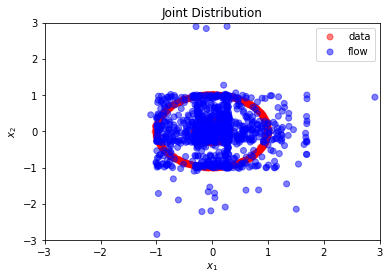

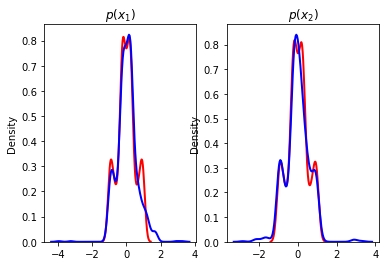

CPU times: user 7.39 s, sys: 843 ms, total: 8.23 s
Wall time: 8.47 s


In [7]:
%%time
class UnivariateModel(FlowBased):
    def __init__(self):
        super().__init__()
        # NOTE: Flows require a stable latent to target. Thus we don't put these on the computation graph.
        self.register_buffer('loc', torch.zeros([2], requires_grad=False))
        self.register_buffer('scale', torch.ones([2], requires_grad=False))

    def build_flow(self):
        self.spline_transform = T.Spline(2, count_bins=16)

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        flow_dist = dist.TransformedDistribution(dist_base, [self.spline_transform])
        xs = pyro.sample('x1_x2', flow_dist.to_event(1))
        # account for batching
        return (xs[:,0], xs[:,1]) if len(xs.shape) == 2 else (xs[0], xs[1])

model = UnivariateModel()
smoke_test(model)

losses = train(model, n_epochs=1 if is_smoke_test else 1000, n_samples=1000, over_vars=['x1_x2'])
visualize(model)

## Flow-Based Multivariate Model

The following is an application of the [Multivariate Distribution Transforms (Pyro Example)](https://pyro.ai/examples/normalizing_flows_i.html#Multivariate-Distributions) in this new PyroModule Framework.

(tensor(-0.5649, grad_fn=<SelectBackward>), tensor(-0.5952, grad_fn=<SelectBackward>))
torch.Size([13])


100%|██████████| 1000/1000 [00:14<00:00, 69.91it/s, loss: -0.207510]


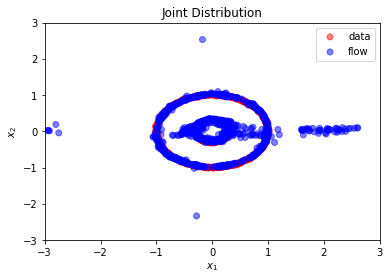

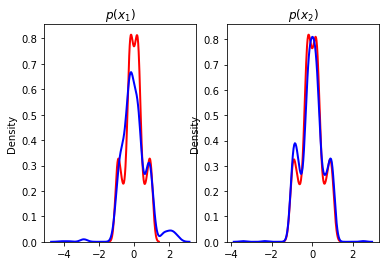

CPU times: user 13.8 s, sys: 1.35 s, total: 15.2 s
Wall time: 15.4 s


In [8]:
%%time

class MultivariateModel(FlowBased):
    def __init__(self):
        super().__init__()
        self.register_buffer('loc', torch.zeros([2], requires_grad=False))
        self.register_buffer('scale', torch.ones([2], requires_grad=False))

    def build_flow(self):
        self.spline_transform = T.spline_coupling(2, count_bins=16)

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        flow_dist = dist.TransformedDistribution(dist_base, [self.spline_transform])
        xs = pyro.sample('x1_x2', flow_dist)
        # account for batching
        return (xs[:,0], xs[:,1]) if len(xs.shape) == 2 else (xs[0], xs[1])

model = MultivariateModel()
smoke_test(model)

losses = train(model, n_epochs=1 if is_smoke_test else 1000, n_samples=1000, over_vars=['x1_x2'])
visualize(model)

## Basic Flow-Based Conditional Model

The following is an application of the [Conditional Distribution Transforms (Pyro Example)](https://pyro.ai/examples/normalizing_flows_i.html#Conditional-versus-Joint-Distributions) in this new PyroModule Framework. 

(tensor([0.6125], grad_fn=<IndexPutBackward>), tensor([1.0471], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|██████████| 5000/5000 [01:04<00:00, 78.06it/s, loss: -0.638323]


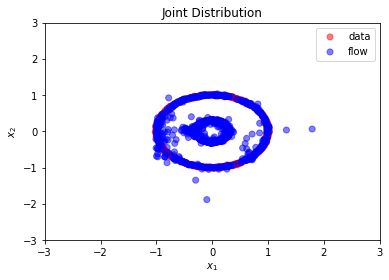

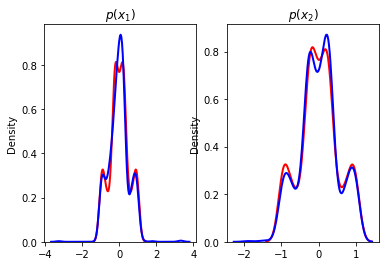

CPU times: user 1min 1s, sys: 4.41 s, total: 1min 6s
Wall time: 1min 5s


In [9]:
%%time
class ConditionalModel(FlowBased):
    def __init__(self):
        super().__init__()
        # NOTE: Flows require a stable latent to target. Thus we don't put these on the computation graph.
        self.register_buffer('loc', torch.zeros([1], requires_grad=False))
        self.register_buffer('scale', torch.ones([1], requires_grad=False))

    def build_flow(self):
        self.x1_transform = T.spline(1)
        self.x2_transform = T.conditional_spline(1, context_dim=1)   # placed in parameters

    def model(self):
        dist_base = dist.Normal(self.loc, self.scale)
        dist_x1 = dist.TransformedDistribution(dist_base, [self.x1_transform])
        dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [self.x2_transform])
        x1 = pyro.sample('x1', dist_x1.to_event(1))
        x2 = pyro.sample('x2', dist_x2_given_x1.condition(x1.detach()).to_event(1))
        return x1, x2

model = ConditionalModel()
smoke_test(model)

losses = train(model, over_vars=['x1', 'x2'], n_epochs=(1 if is_smoke_test else 5000), n_samples=1000)
if not is_smoke_test:
    visualize(model)

# Adding More Complexity to Conditional Models

Now, building from the [Conditional Distribution Transforms (Pyro Example)](https://pyro.ai/examples/normalizing_flows_i.html#Conditional-versus-Joint-Distributions), additional variables are added to demonstrate ability to train the model on these variables. Gradually, complexity is added to model to demonstrate how each addition of a variable and context changes the structure of the PyroModule Framework.

## Basic Conditional Model with Additional Noise Variable

(tensor([-0.4528], grad_fn=<IndexPutBackward>), tensor([-0.7863], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|██████████| 5000/5000 [01:19<00:00, 62.73it/s, loss: 0.570343]


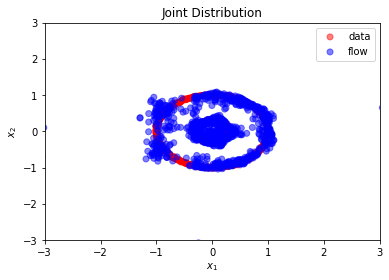

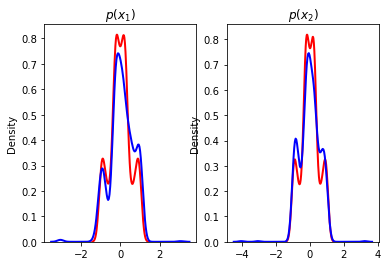

In [10]:
class NoiseModel(FlowBased):
    def __init__(self):
        super().__init__()

    def build_flow(self):
        self.register_buffer('noise_base_loc', torch.zeros([1], requires_grad=False))
        self.register_buffer('noise_base_scale', torch.ones([1], requires_grad=False))
        self.noise_flow_lognorm = AffineTransform(loc=self.noise_base_loc.item(), scale=self.noise_base_scale.item())
        self.x1_transform = T.conditional_spline(1, context_dim=1)
        self.x2_transform = T.conditional_spline(1, context_dim=2)   # placed in parameters

    def model(self):
        noise_base_dist = dist.Normal(self.noise_base_loc, self.noise_base_scale)
        dist_noise = dist.TransformedDistribution(noise_base_dist, [self.noise_flow_lognorm])

        dist_x1_given_noise = dist.ConditionalTransformedDistribution(dist_noise, [self.x1_transform])
        dist_x2_given_noise = dist.ConditionalTransformedDistribution(dist_noise, [self.x2_transform])

        noise = pyro.sample('noise', dist_noise.to_event(1))
        x1 = pyro.sample('x1', dist_x1_given_noise.condition(noise.detach()).to_event(1))
        ctx = torch.cat([noise.detach(), x1.detach()], dim=-1)
        x2 = pyro.sample('x2', dist_x2_given_noise.condition(ctx).to_event(1))
        return x1, x2

model = NoiseModel()
smoke_test(model)

losses = train(model, over_vars=['x1', 'x2', 'noise'], n_epochs=(1 if is_smoke_test else 5000), n_samples=1000)
if not is_smoke_test:
    visualize(model)

## Flow-Based Conditional Model with Continuous Context Variables

(tensor([-1.4650], grad_fn=<IndexPutBackward>), tensor([0.7994], grad_fn=<IndexPutBackward>))
torch.Size([13, 1])


100%|██████████| 10000/10000 [03:08<00:00, 53.18it/s, loss: 1.197952]


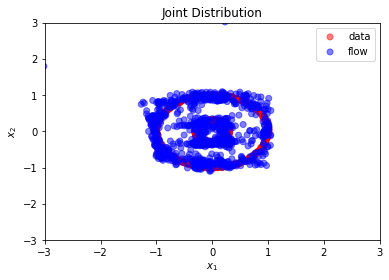

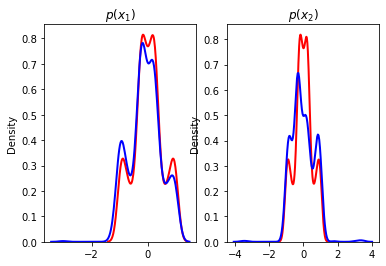

In [11]:
class ContinuousModel(FlowBased):
    def __init__(self):
        super().__init__()
        #self.label_logits = torch.nn.Parameter(torch.zeros([1, ]))

    def register_buffers(self):
        return dict(
            x1_base_loc=torch.zeros([1]),     x1_base_scale=torch.ones([1]),
            x2_base_loc=torch.zeros([1]),     x2_base_scale=torch.ones([1]),
            noise_base_loc=torch.zeros([1]),  noise_base_scale=torch.ones([1]),
            factor_base_loc=torch.zeros([1]), factor_base_scale=torch.ones([1]),
        )

    def build_flow(self):
        self.x1_flow_lognorm = AffineTransform(loc=self.x1_base_loc.item(), scale=self.x1_base_scale.item())
        self.x2_flow_lognorm = AffineTransform(loc=self.x2_base_loc.item(), scale=self.x2_base_scale.item())
        self.noise_flow_lognorm = AffineTransform(loc=self.noise_base_loc.item(), scale=self.noise_base_scale.item())
        self.factor_flow_lognorm = AffineTransform(loc=self.factor_base_loc.item(), scale=self.factor_base_scale.item())

        self.x1_transform = T.conditional_spline(1, context_dim=2, count_bins=16)
        self.x2_transform = T.conditional_spline(1, context_dim=3, count_bins=16)   # placed in parameters

    def model(self):
        x1_base_dist = dist.Normal(self.x1_base_loc, self.x1_base_scale)
        dist_x1 = dist.TransformedDistribution(x1_base_dist, [self.x1_flow_lognorm])

        x2_base_dist = dist.Normal(self.x2_base_loc, self.x2_base_scale)
        dist_x2 = dist.TransformedDistribution(x2_base_dist, [self.x2_flow_lognorm])

        noise_base_dist = dist.Normal(self.noise_base_loc, self.noise_base_scale)
        dist_noise = dist.TransformedDistribution(noise_base_dist, [self.noise_flow_lognorm])

        factor_base_dist = dist.Normal(self.factor_base_loc, self.factor_base_scale)
        dist_factor = dist.TransformedDistribution(factor_base_dist, [self.factor_flow_lognorm])

        cond_dist_x1 = dist.ConditionalTransformedDistribution(dist_x1, [self.x1_transform])
        cond_dist_x2 = dist.ConditionalTransformedDistribution(dist_x2, [self.x2_transform])

        noise = pyro.sample('noise', dist_noise.to_event(1))
        factor = pyro.sample('factor', dist_factor.to_event(1))
        ctx1 = torch.cat([noise.detach(), factor.detach()], dim=-1)
        x1 = pyro.sample('x1', cond_dist_x1.condition(ctx1).to_event(1))

        ctx2 = torch.cat([ctx1.detach(), x1.detach()], dim=-1)
        x2 = pyro.sample('x2', cond_dist_x2.condition(ctx2).to_event(1))
        return x1, x2

model = ContinuousModel()
smoke_test(model)

losses = train(model, over_vars=['x1', 'x2', 'noise', 'factor'], n_epochs=(1 if is_smoke_test else 10000), n_samples=1000)
if not is_smoke_test:
    visualize(model)

# Implementation of Structural Causal Model with Normalizing Flows and Counterfactual Inference

The Causal DAG of the following SCM:

<img src="counterfactual_donuts.png">

## Structural Causal Model for Conditional Distributions

In non-technical terms, SCMs can be thought of as DAGs where for each variable in the DAG we reify the randomness as distinct from causal mechanisms, or functions. 

An SCM consists of a collection of independent exogenous noise variables and endogenous variables with values assigned by functions of exogenous noise and other endogenous variables. These models are typically acyclic, and they entail distributions that may be represented as DAGs over the endogenous variables.

SCMs may admit counterfactual inference because we can infer the values of the exogenous noise conditioned on a sample, change values of the endogenous variables, and then play forward the model under the change.

In [13]:
class ContinuousSCMModel(FlowBased):
    def __init__(self):
        super().__init__()

    def register_buffers(self):
        return dict(
            x1_base_loc=torch.zeros([1]),     x1_base_scale=torch.ones([1]),
            x2_base_loc=torch.zeros([1]),     x2_base_scale=torch.ones([1]),
            noise_base_loc=torch.zeros([1]),  noise_base_scale=torch.ones([1]),
            factor_base_loc=torch.zeros([1]), factor_base_scale=torch.ones([1]),
            noise_flow_norm_loc=torch.zeros([1]), noise_flow_norm_scale=torch.ones([1]),
            factor_flow_norm_loc=torch.zeros([1]), factor_flow_norm_scale=torch.ones([1]),
        )

    def build_flow(self):
        self.x1_flow_lognorm = AffineTransform(loc=self.x1_base_loc.item(), scale=self.x1_base_scale.item())
        self.x2_flow_lognorm = AffineTransform(loc=self.x2_base_loc.item(), scale=self.x2_base_scale.item())
        self.noise_flow_lognorm = AffineTransform(loc=self.noise_base_loc.item(), scale=self.noise_base_scale.item())
        self.factor_flow_lognorm = AffineTransform(loc=self.factor_base_loc.item(), scale=self.factor_base_scale.item())

        self.x1_transform = T.conditional_spline(1, context_dim=2, count_bins=16)
        self.x2_transform = T.conditional_spline(1, context_dim=3, count_bins=16)   # placed in parameters

        # parametrizes the noise flow base distribution
        self.noise_flow_norm = AffineTransform(loc=self.noise_flow_norm_loc.item(), scale=self.noise_flow_norm_scale.item())

        # parametrizes the factor flow base distribution
        self.factor_flow_norm = AffineTransform(loc=self.factor_flow_norm_loc.item(), scale=self.factor_flow_norm_scale.item())

        # flow for modeling noise
        self.noise_spline, self.noise_sigmoid = T.Spline(1), SigmoidTransform()
        self.noise_flow_components = ComposeTransformModule([self.noise_spline])
        self.noise_flow_constraint_transforms = ComposeTransform([self.noise_flow_norm, self.noise_sigmoid])
        self.noise_flow_transforms = ComposeTransform([self.noise_flow_components, self.noise_flow_constraint_transforms])
        
        # flow for modeling factor variable, conditioned on the noise value
        factor_net = DenseNN(1, [1], param_dims=[1, 1], nonlinearity=nn.Identity())
        self.factor_flow_components = ConditionalAffineTransform(context_nn=factor_net, event_dim=0)
        self.factor_sigmoid = SigmoidTransform()
        self.factor_flow_constraint_transforms = ComposeTransform([self.factor_flow_norm, self.factor_sigmoid])
        self.factor_flow_transforms = [self.factor_flow_components, self.factor_flow_constraint_transforms]

    def pgm_model(self):
        # create noise distribution
        noise_base_dist = dist.Normal(self.noise_base_loc, self.noise_base_scale).to_event(1) # FIXME
        self.noise_dist = dist.TransformedDistribution(noise_base_dist, self.noise_flow_transforms)
        
        # sample noise value
        noise = pyro.sample('noise', self.noise_dist)
        noise_ = self.noise_flow_constraint_transforms.inv(noise) # transformed version of N_noise
        # pseudo call to noise_flow_transforms to register with pyro
        _ = self.noise_flow_components
        
        # create factor distribution
        factor_base_dist = dist.Normal(self.factor_base_loc, self.factor_base_scale).to_event(1)
        self.factor_dist = dist.ConditionalTransformedDistribution(base_dist=factor_base_dist, transforms=self.factor_flow_transforms).condition(noise_)
        
        # sample factor value
        factor = pyro.sample('factor', self.factor_dist)
        # psuedo call to factor_flow_components to register with pyro
        _ = self.factor_flow_components

        return noise, factor

    def model(self):
        noise, factor = self.pgm_model()

        x1_base_dist = dist.Normal(self.x1_base_loc, self.x1_base_scale)
        dist_x1 = dist.TransformedDistribution(x1_base_dist, [self.x1_flow_lognorm])

        x2_base_dist = dist.Normal(self.x2_base_loc, self.x2_base_scale)
        dist_x2 = dist.TransformedDistribution(x2_base_dist, [self.x2_flow_lognorm])

        cond_dist_x1 = dist.ConditionalTransformedDistribution(dist_x1, [self.x1_transform])
        cond_dist_x2 = dist.ConditionalTransformedDistribution(dist_x2, [self.x2_transform])

        ctx1 = torch.cat([noise.detach(), factor.detach()], dim=-1)
        x1 = pyro.sample('x1', cond_dist_x1.condition(ctx1).to_event(1))

        ctx2 = torch.cat([ctx1.detach(), x1.detach()], dim=-1)
        x2 = pyro.sample('x2', cond_dist_x2.condition(ctx2).to_event(1))
        return x1, x2, noise, factor

    def infer_exogenous(self, **obs):
        cond_sample = pyro.condition(self.model, data=obs)
        cond_trace = poutine.trace(cond_sample).get_trace()

        output = {}
        for name, node in cond_trace.nodes.items():
            if 'fn' not in node.keys():
                continue

            fn = node['fn']
            if isinstance(fn, Independent):
                fn = fn.base_dist
            if isinstance(fn, TransformedDistribution):
                output[name + '_base'] = ComposeTransform(fn.transforms).inv(node['value'])
        return output
    
    def counterfactual(self, obs, condition=None):
        exogenous = self.infer_exogenous(**obs)
        counter = poutine.do(poutine.condition(self.scm, data=exogenous), data=condition)()
        return {k: v for k, v in zip(( 'x1', 'x2', 'noise', 'factor'), counter)}
    
    @pyro_method
    def scm(self, *args, **kwargs):
        def config(msg):
            if isinstance(msg['fn'], TransformedDistribution):
                return TransformReparam()
            else:
                return None

        return pyro.poutine.reparam(self.model, config=config)(*args, **kwargs)
    
    @pyro_method
    def sample_scm(self, n_samples=1):
        with pyro.plate('observations', n_samples):
            samples = self.scm()

        return (*samples,)

model = ContinuousSCMModel()
smoke_test(model)

is_smoke_test = False
losses = train(model, over_vars=['x1', 'x2', 'noise', 'factor'], n_epochs=(1 if is_smoke_test else 5000), n_samples=1000)

(tensor([-1.1765], grad_fn=<IndexPutBackward>), tensor([-0.6714], grad_fn=<IndexPutBackward>), tensor([0.8658], grad_fn=<ClampBackward>), tensor([0.0594], grad_fn=<ClampBackward>))
torch.Size([13, 1])


100%|██████████| 5000/5000 [02:01<00:00, 41.07it/s, loss: -1.379781] 


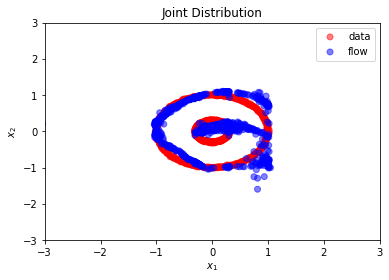

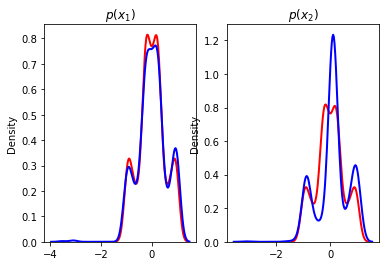

In [14]:
visualize(model)

# Twin-World Counterfactual Inference Algorithm

### Infer Exogenous Variables and Perform Counterfactual Query

In the abduction-action-inference algorithm, we use our variables X1 and X2 (sample) in the current world to infer the exogenous noise variables (i.e. conditions that lead to this sample). Then, we condition our model on these exogenous noise variables to propogate these conditions into this twin world and subsequently mutilate our model with a do operation under the specified counterfactual condition (i.e. factor = 0.1) to forward simulate the twin world alternatives X1' and X2' under this new counterfactual distribution. 

In [15]:
with torch.no_grad():
    model_trace = poutine.trace(model.model).get_trace()
    sample = {k: model_trace.nodes[k]['value'] for k in  ['factor', 'noise', 'x1', 'x2']}
    print(sample)
    print(model.infer_exogenous(**sample))
    print(model.counterfactual(obs=sample, condition=dict(factor=torch.tensor([0.1]))))
    
    many = [model.counterfactual(obs=sample, condition=dict(factor=torch.tensor([0.1]))) for _ in range(1000)]

{'factor': tensor([0.3757]), 'noise': tensor([0.8435]), 'x1': tensor([-0.0119]), 'x2': tensor([0.1162])}
{'noise_base': tensor([-0.7533]), 'factor_base': tensor([-0.2410]), 'x1_base': tensor([-0.0232]), 'x2_base': tensor([0.1152])}
{'x1': tensor([-0.8214]), 'x2': tensor([-0.3753]), 'noise': tensor([0.8435]), 'factor': tensor([0.1000])}


## Plot the Twin World Counterfactual Result

For the counterfactual twin world, we performed the $do(factor := \hat{0.1})$ mutilation and in our resulting forward simulated x1,x2 alternatives we see below that the factor between the two circles change in accordance from our change in factor from 0.3 to 0.1 in comparison of the above and below images.

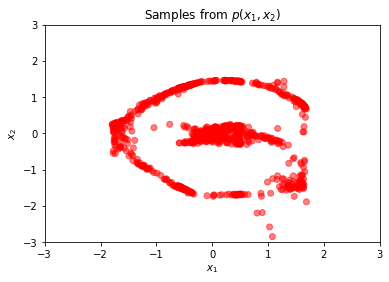

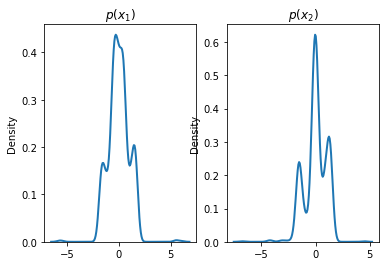

In [16]:
X = torch.stack(list(map(lambda x: torch.cat([x['x1'], x['x2']]), many)))
plot(X[:,0].view(-1,1), X[:,1].view(-1,1), torch.ones_like(X[:,1]).view(-1,1))

# Resources
* https://pyro.ai/examples/normalizing_flows_i.html#Conditional-versus-Joint-Distributions
* http://pyro.ai/examples/tensor_shapes.html
* http://docs.pyro.ai/en/stable/distributions.html#transforms
* https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html
* https://pytorch.org/docs/master/optim.html#torch.optim.Optimizer
* https://readthedocs.org/projects/pyro-ppl/downloads/pdf/stable/
* https://arxiv.org/pdf/2006.06485.pdf
* https://github.com/biomedia-mira/deepscm
* http://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.transforms.SplineCoupling